In [1]:

"""
---------------------------------
Clase C817 - UNI FIC
Prof. Alan Ayala, PhD. 
---------------------------------

Solución de la ecuación de Navier Stokes equations en una cavidad con una tapa
movediza usando el método de elementos finitos y proyecciones de Chorin.
Ver pag. 64 del manual de FreeFem++

Ecuación de Momentos: 
          ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f

Condición de incomprensibilidad:  ∇ ⋅ u = 0

Variables y Parámetros:

u:  Velocity (2d vector)
p:  Pressure
f:  Forcing (here =0)
ν:  Kinematic Viscosity
ρ:  Density (here =1)
t:  Time
∇:  Nabla operator (defining nonlinear convection, gradient and divergence)
∇²: Laplace Operator

----

Escenario gráfico:
                            ------>>>>> u_top

          1 +-------------------------------------------------+
            |                                                 |
            |             *                      *            |
            |          *           *    *    *                |
        0.8 |                                                 |
            |                                 *               |
            |     *       *                                   |
            |                      *     *                    |
        0.6 |                                            *    |
u = 0       |      *                             *            |   u = 0
v = 0       |                             *                   |   v = 0
            |                     *                           |
            |           *                *         *          |
        0.4 |                                                 |
            |                                                 |
            |      *            *             *               |
            |           *                             *       |
        0.2 |                       *           *             |
            |                               *                 |
            |  *          *      *                 *       *  |
            |                            *                    |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

                                    u = 0
                                    v = 0


Condiciones de borde:
* Todas las componentes de velocidad son 0 en el tiempo 0 en todos los bordes,
* excepto en la tapa.
"""

'\nSolución de la ecuación de Navier Stokes equations en una cavidad con una tapa\nmovediza usando el método de elementos finitos y proyecciones de Chorin.\nVer pag. 64 del manual de FreeFem++\n\nEcuación de Momentos: \n          ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f\n\nCondición de incomprensibilidad:  ∇ ⋅ u = 0\n\nVariables y Parámetros:\n\nu:  Velocity (2d vector)\np:  Pressure\nf:  Forcing (here =0)\nν:  Kinematic Viscosity\nρ:  Density (here =1)\nt:  Time\n∇:  Nabla operator (defining nonlinear convection, gradient and divergence)\n∇²: Laplace Operator\n\n----\n\nEscenario gráfico:\n                            ------>>>>> u_top\n\n          1 +-------------------------------------------------+\n            |                                                 |\n            |             *                      *            |\n            |          *           *    *    *                |\n        0.8 |                                                 |\n            |               

In [11]:
from fenics import *
from mshr import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
# Parámetros:
N_POINTS_P_AXIS = 41
TIME_STEP_LENGTH = 0.01
N_TIME_STEPS = 100
KINEMATIC_VISCOSITY = 0.01 # -> Re = 100

In [14]:
mesh = UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS)

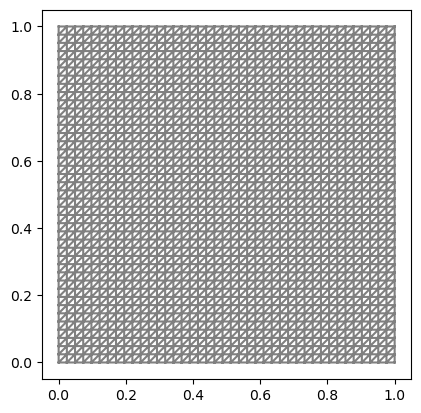

In [15]:
plot(mesh)

In [16]:
# Elementos tipo Taylor-Hood.
# Espacio de funciones para la presión debe ser de un orden menor que de velocidad.
velocity_function_space = VectorFunctionSpace(mesh, "Lagrange", 2)
pressure_function_space = FunctionSpace(mesh, "Lagrange", 1)

u_trial = TrialFunction(velocity_function_space)
p_trial = TrialFunction(pressure_function_space)
v_test = TestFunction(velocity_function_space)
q_test = TestFunction(pressure_function_space)

In [17]:
# Condición de borde
stationary_wall_boundary_condition = DirichletBC(
    velocity_function_space,
    (0.0, 0.0),
    """
    on_boundary && (x[0] < DOLFIN_EPS || x[1] < DOLFIN_EPS || x[0] > (1.0 - DOLFIN_EPS))
    """
)
moving_wall_boundary_condition = DirichletBC(
    velocity_function_space,
    (1.0, 0.0),
    """
    on_boundary && (x[1] > (1.0 - DOLFIN_EPS))
    """
)
velocity_boundary_conditions = [stationary_wall_boundary_condition, moving_wall_boundary_condition]


In [18]:
# Vectores de velocidad y presión
u_prev = Function(velocity_function_space)
u_tent = Function(velocity_function_space)
u_next = Function(velocity_function_space)
p_next = Function(pressure_function_space)

In [20]:
# Forma débil de la ecuación de momento
momentum_weak_form_residuum = (
    1.0 / TIME_STEP_LENGTH * inner(u_trial - u_prev, v_test) * dx
    +
    inner(grad(u_prev) * u_prev, v_test) * dx
    +
    KINEMATIC_VISCOSITY * inner(grad(u_trial), grad(v_test)) * dx
)
momentum_weak_form_lhs = lhs(momentum_weak_form_residuum)
momentum_weak_form_rhs = rhs(momentum_weak_form_residuum)

# Forma débil de la ecuación de presión
pressure_poisson_weak_form_lhs = inner(grad(p_trial), grad(q_test)) * dx
pressure_poisson_weak_form_rhs = - 1.0 / TIME_STEP_LENGTH * div(u_tent) * q_test * dx

# Forma débil de la ecuación de velocidad
velocity_update_weak_form_lhs = inner(u_trial, v_test) * dx
velocity_update_weak_form_rhs = (
    inner(u_tent, v_test) * dx
    -
    TIME_STEP_LENGTH * inner(grad(p_next), v_test) * dx
)


In [21]:
# Pre-ensamblaje de sistema de matrices
momentum_assembled_system_matrix = assemble(momentum_weak_form_lhs)
pressure_poisson_assembled_system_matrix = assemble(pressure_poisson_weak_form_lhs)
velocity_update_assembled_system_matrix = assemble(velocity_update_weak_form_lhs)


  0%|          | 0/100 [00:00<?, ?it/s]

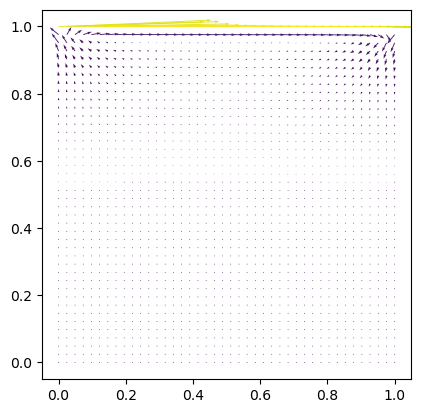

  1%|          | 1/100 [00:00<00:10,  9.20it/s]

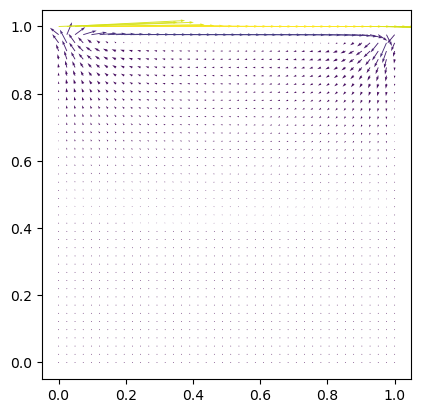

  2%|▏         | 2/100 [00:00<00:10,  9.61it/s]

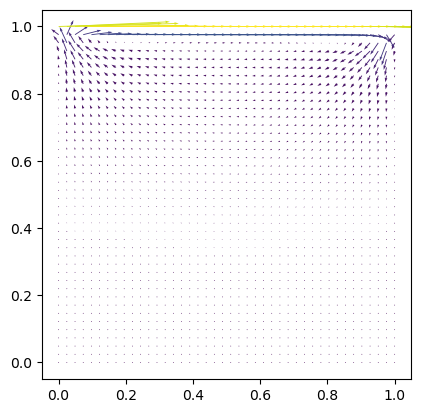

  3%|▎         | 3/100 [00:00<00:12,  7.68it/s]

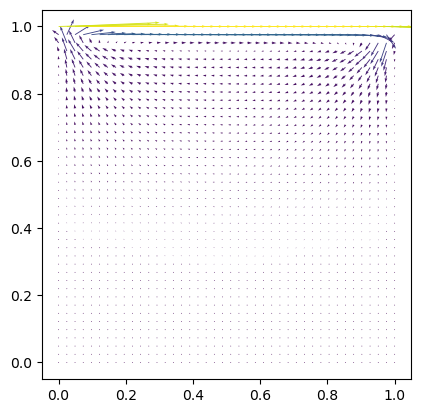

  4%|▍         | 4/100 [00:00<00:11,  8.39it/s]

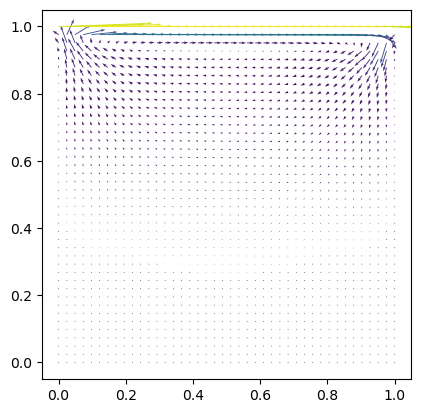

  5%|▌         | 5/100 [00:00<00:10,  8.85it/s]

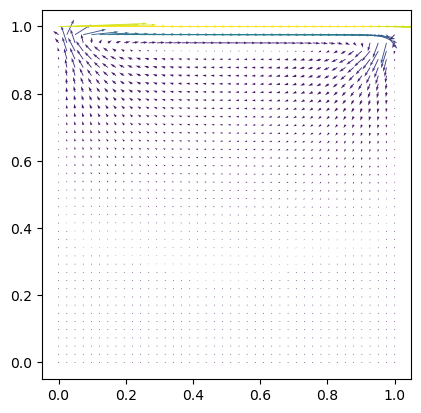

  6%|▌         | 6/100 [00:00<00:10,  9.14it/s]

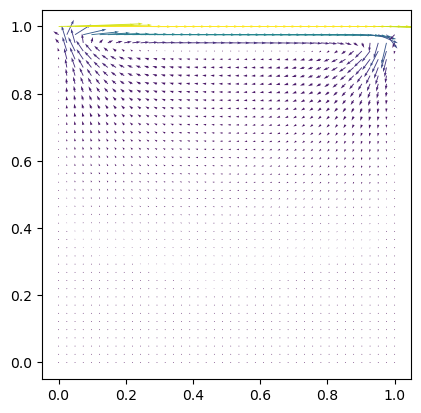

  7%|▋         | 7/100 [00:00<00:09,  9.32it/s]

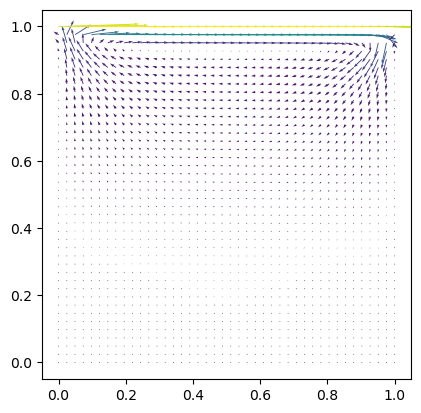

  8%|▊         | 8/100 [00:00<00:09,  9.41it/s]

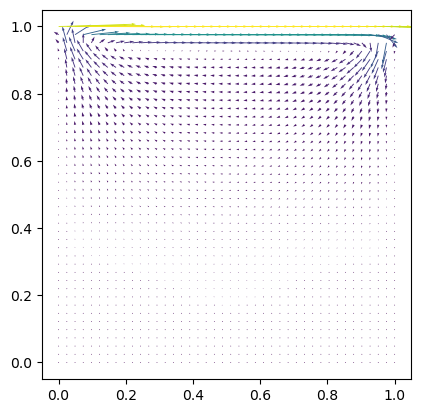

  9%|▉         | 9/100 [00:00<00:09,  9.51it/s]

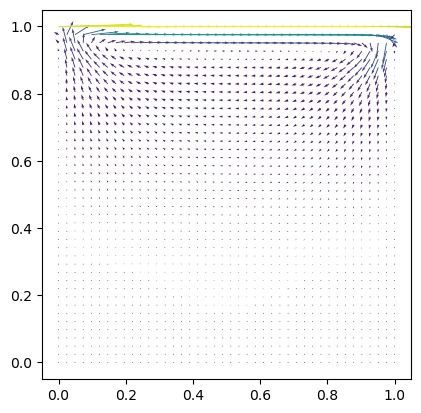

 10%|█         | 10/100 [00:01<00:09,  9.59it/s]

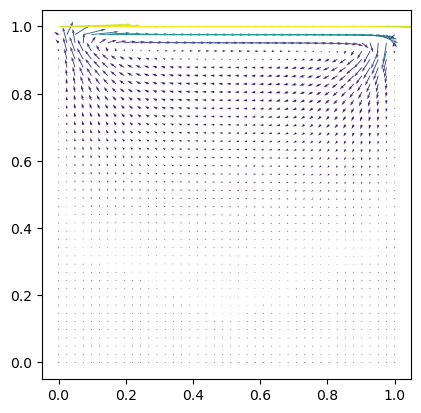

 11%|█         | 11/100 [00:01<00:11,  7.97it/s]

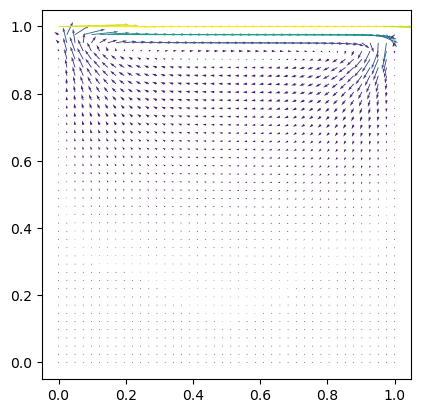

 12%|█▏        | 12/100 [00:01<00:10,  8.23it/s]

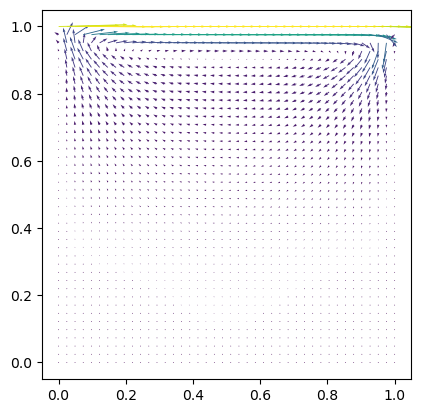

 13%|█▎        | 13/100 [00:01<00:10,  8.61it/s]

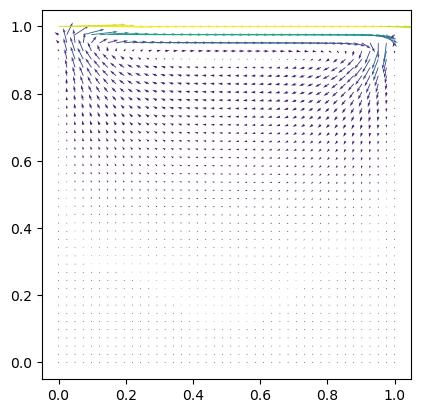

 14%|█▍        | 14/100 [00:01<00:09,  8.91it/s]

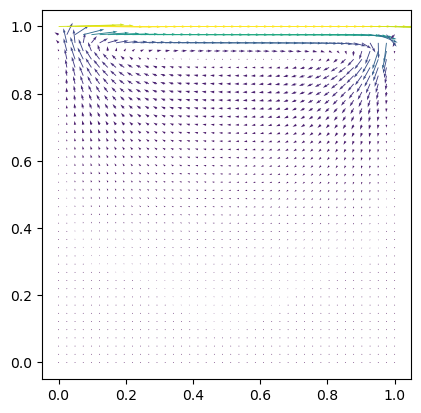

 15%|█▌        | 15/100 [00:01<00:09,  8.96it/s]

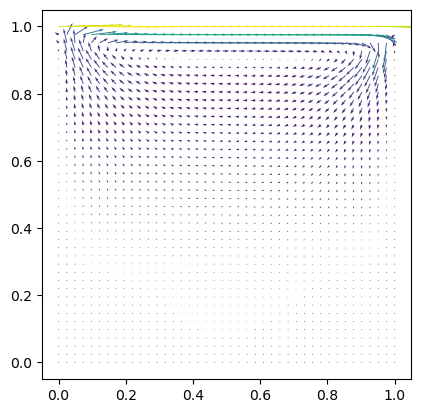

 16%|█▌        | 16/100 [00:01<00:09,  9.11it/s]

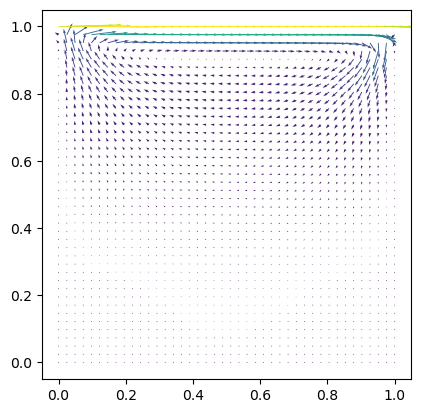

 17%|█▋        | 17/100 [00:01<00:09,  9.16it/s]

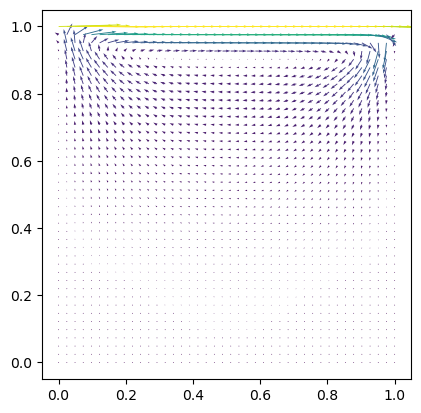

 18%|█▊        | 18/100 [00:02<00:08,  9.26it/s]

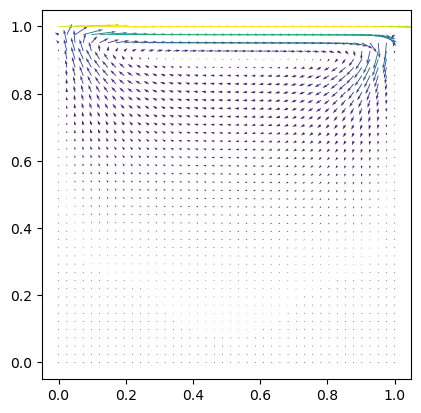

 19%|█▉        | 19/100 [00:02<00:08,  9.33it/s]

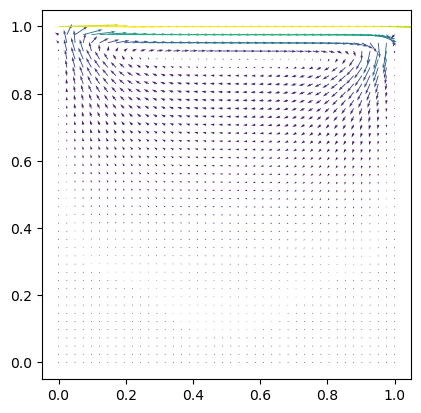

 20%|██        | 20/100 [00:02<00:10,  7.67it/s]

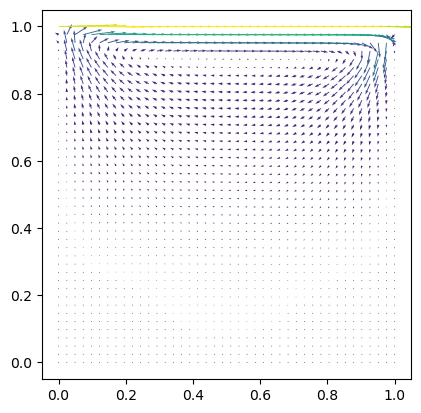

 21%|██        | 21/100 [00:02<00:09,  8.10it/s]

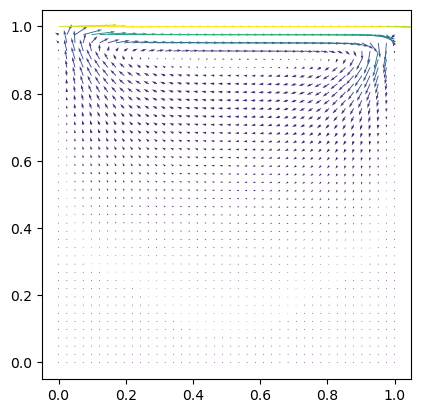

 22%|██▏       | 22/100 [00:02<00:09,  8.45it/s]

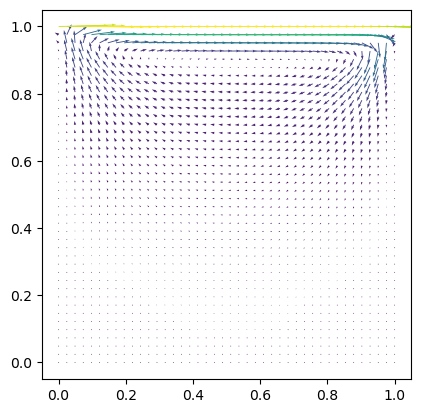

 23%|██▎       | 23/100 [00:02<00:08,  8.68it/s]

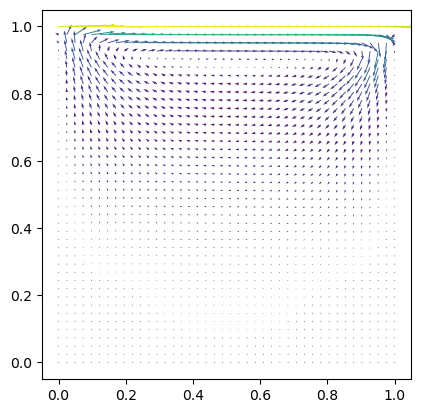

 24%|██▍       | 24/100 [00:02<00:08,  8.90it/s]

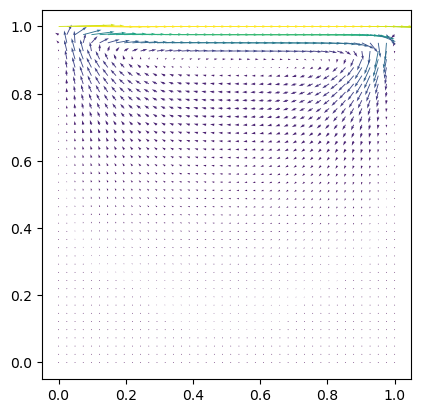

 25%|██▌       | 25/100 [00:02<00:08,  8.94it/s]

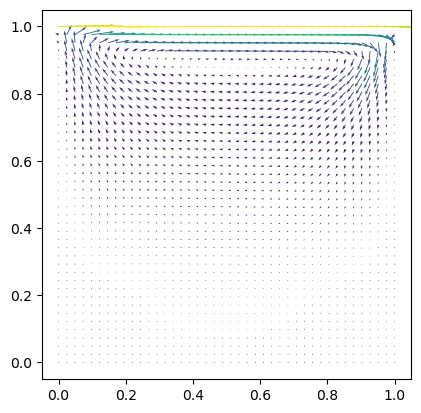

 26%|██▌       | 26/100 [00:02<00:08,  9.09it/s]

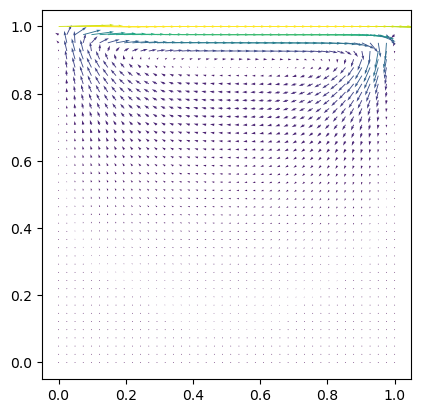

 27%|██▋       | 27/100 [00:03<00:07,  9.15it/s]

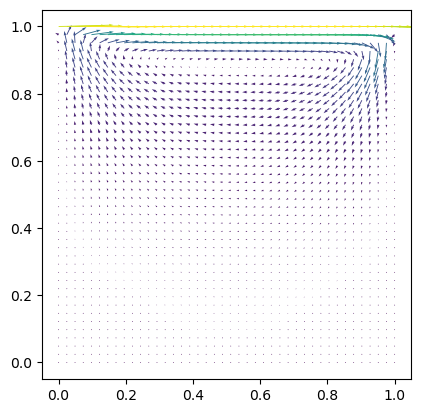

 28%|██▊       | 28/100 [00:03<00:07,  9.20it/s]

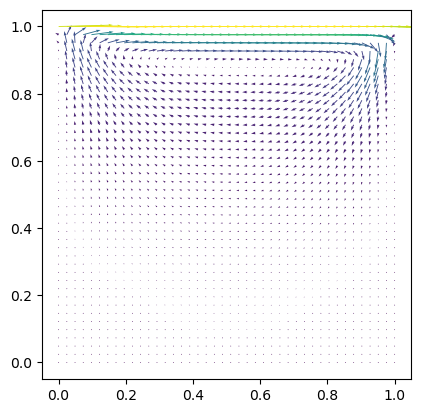

 29%|██▉       | 29/100 [00:03<00:09,  7.74it/s]

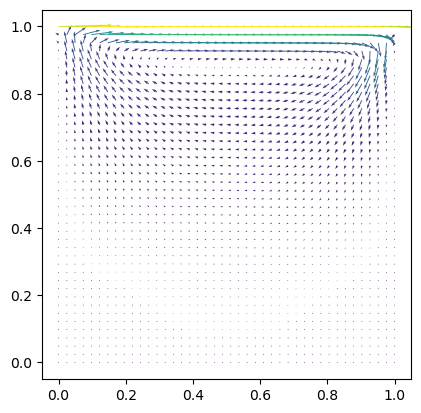

 30%|███       | 30/100 [00:03<00:08,  8.15it/s]

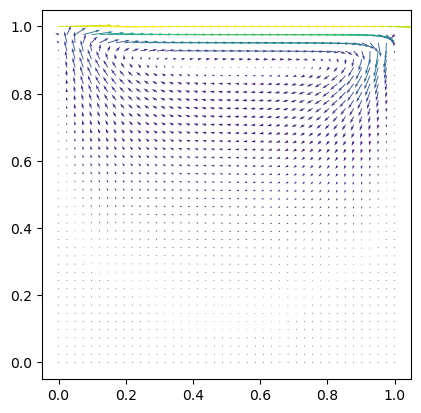

 31%|███       | 31/100 [00:03<00:08,  8.46it/s]

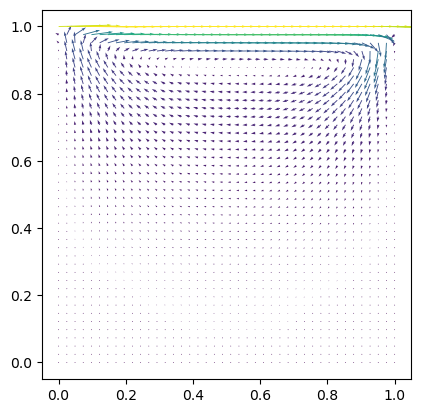

 32%|███▏      | 32/100 [00:03<00:07,  8.72it/s]

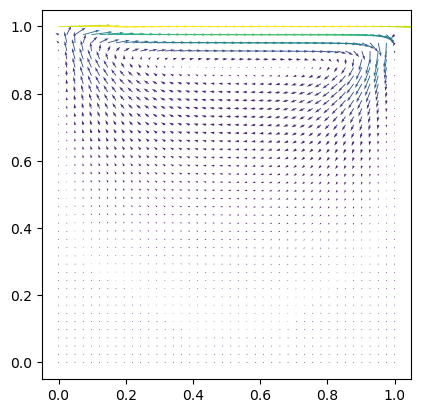

 33%|███▎      | 33/100 [00:03<00:07,  8.87it/s]

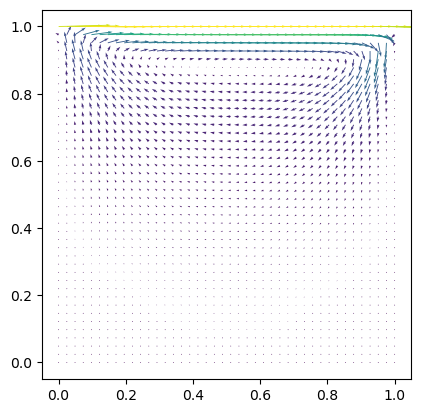

 34%|███▍      | 34/100 [00:03<00:07,  8.98it/s]

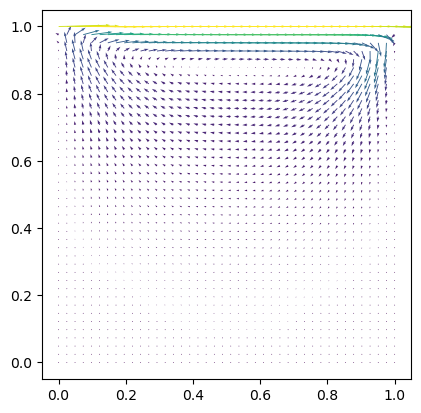

 35%|███▌      | 35/100 [00:03<00:07,  9.01it/s]

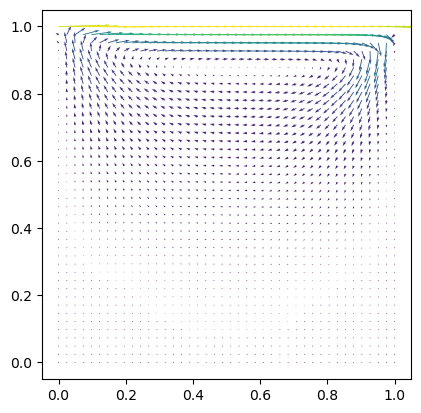

 36%|███▌      | 36/100 [00:04<00:07,  9.07it/s]

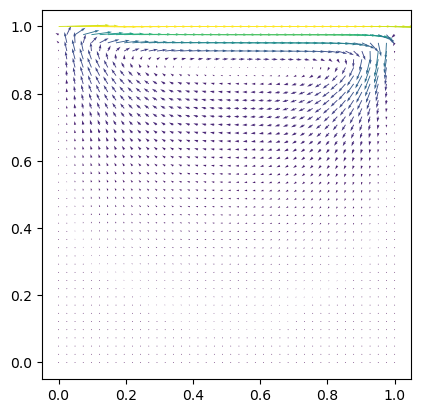

 37%|███▋      | 37/100 [00:04<00:06,  9.12it/s]

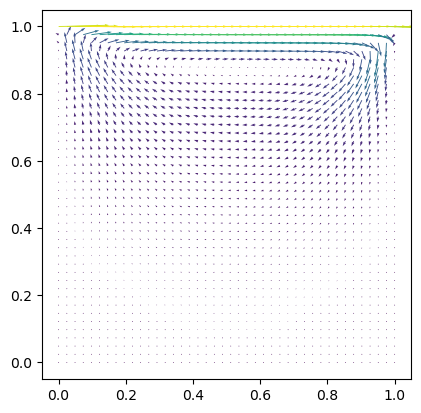

 38%|███▊      | 38/100 [00:04<00:08,  7.63it/s]

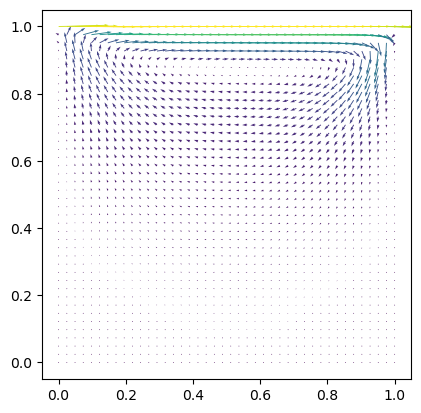

 39%|███▉      | 39/100 [00:04<00:07,  7.99it/s]

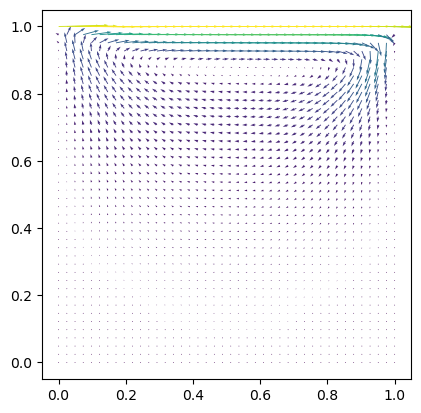

 40%|████      | 40/100 [00:04<00:07,  8.18it/s]

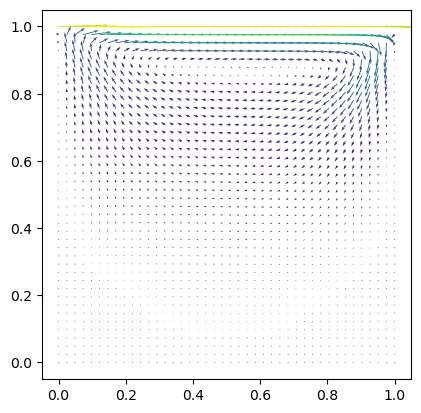

 41%|████      | 41/100 [00:04<00:06,  8.48it/s]

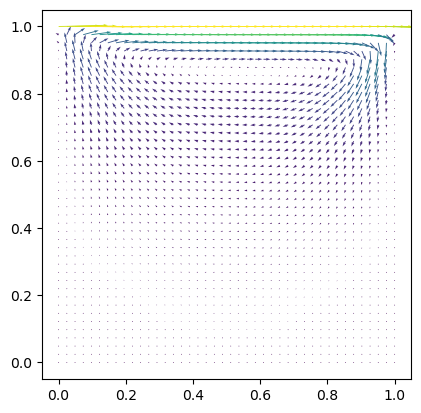

 42%|████▏     | 42/100 [00:04<00:06,  8.73it/s]

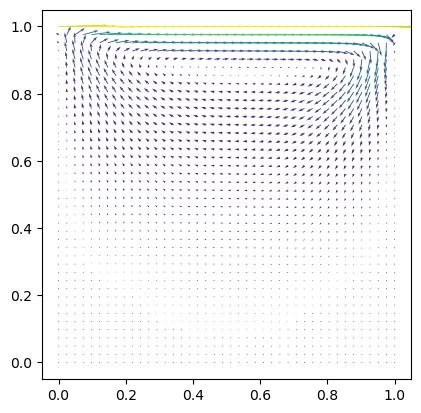

 43%|████▎     | 43/100 [00:04<00:06,  8.74it/s]

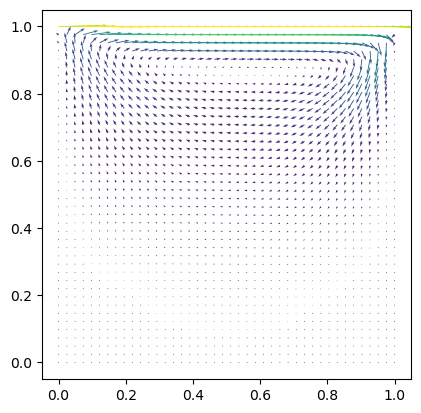

 44%|████▍     | 44/100 [00:05<00:06,  8.67it/s]

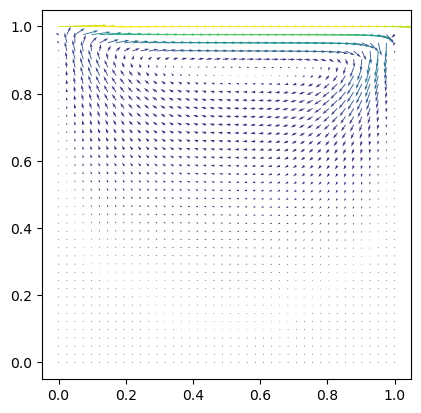

 45%|████▌     | 45/100 [00:05<00:06,  8.71it/s]

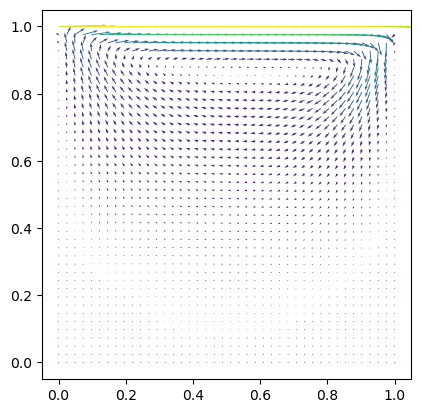

 46%|████▌     | 46/100 [00:05<00:06,  8.92it/s]

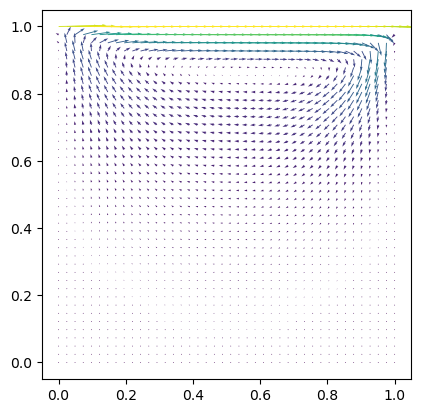

 47%|████▋     | 47/100 [00:05<00:07,  7.52it/s]

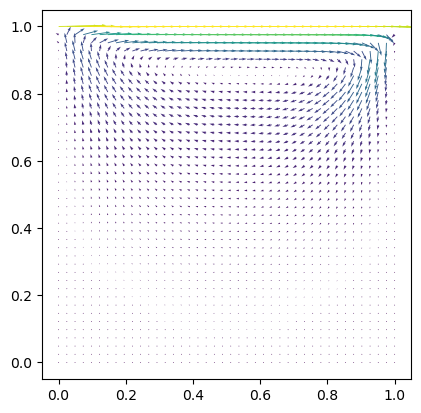

 48%|████▊     | 48/100 [00:05<00:06,  7.98it/s]

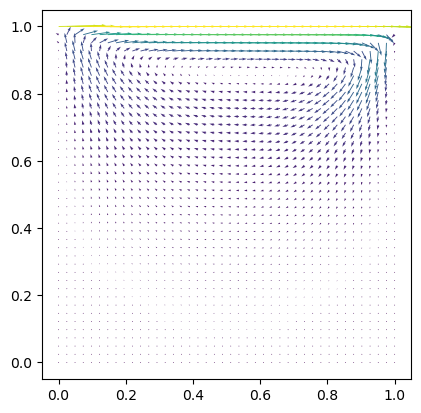

 49%|████▉     | 49/100 [00:05<00:06,  8.33it/s]

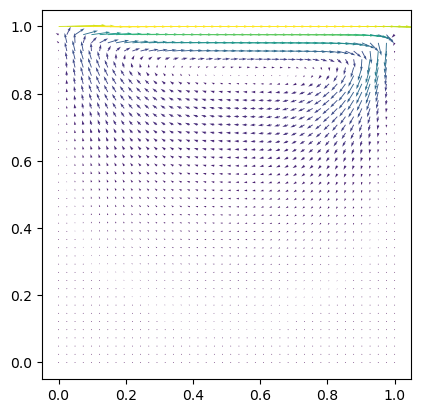

 50%|█████     | 50/100 [00:05<00:05,  8.60it/s]

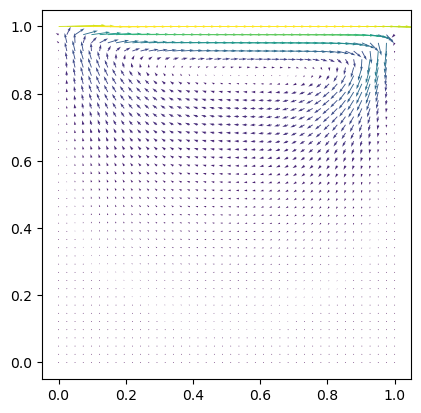

 51%|█████     | 51/100 [00:05<00:05,  8.75it/s]

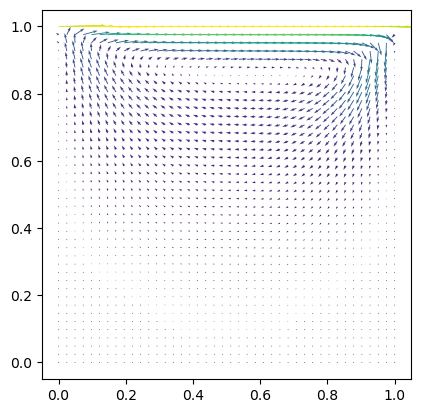

 52%|█████▏    | 52/100 [00:05<00:05,  8.92it/s]

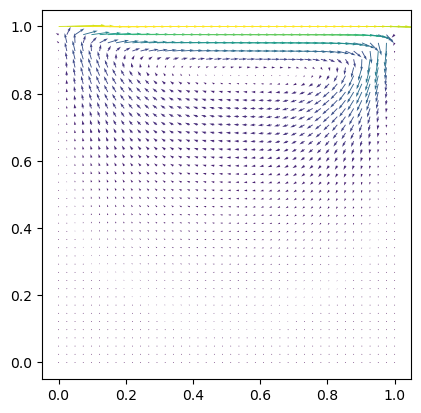

 53%|█████▎    | 53/100 [00:06<00:05,  9.04it/s]

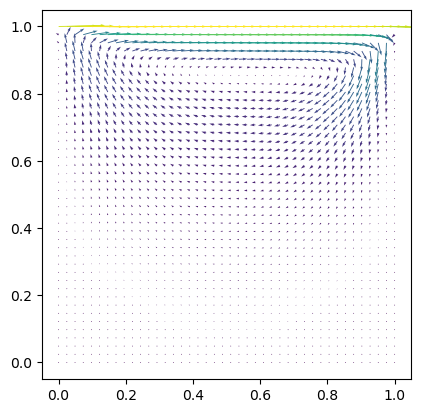

 54%|█████▍    | 54/100 [00:06<00:05,  9.11it/s]

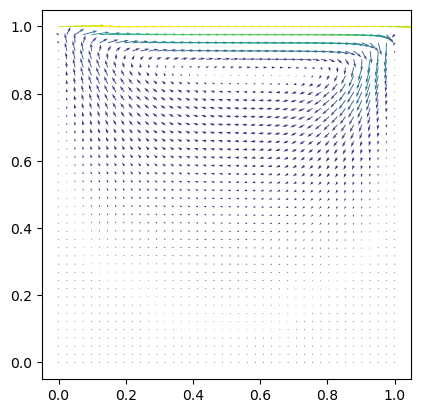

 55%|█████▌    | 55/100 [00:06<00:04,  9.10it/s]

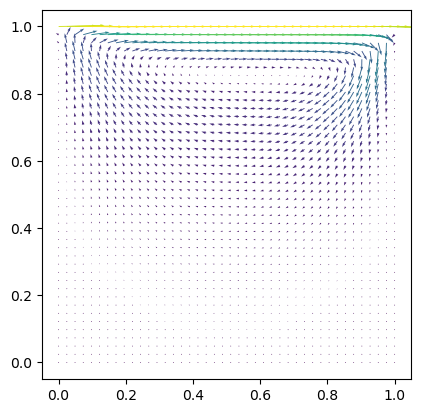

 56%|█████▌    | 56/100 [00:06<00:05,  7.53it/s]

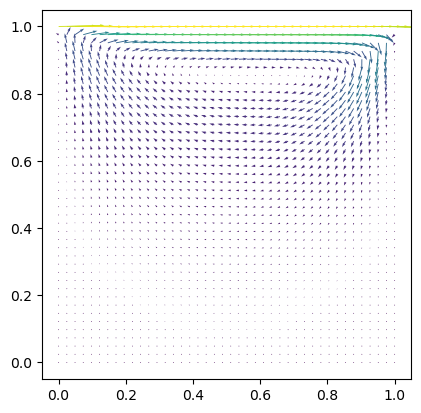

 57%|█████▋    | 57/100 [00:06<00:05,  8.00it/s]

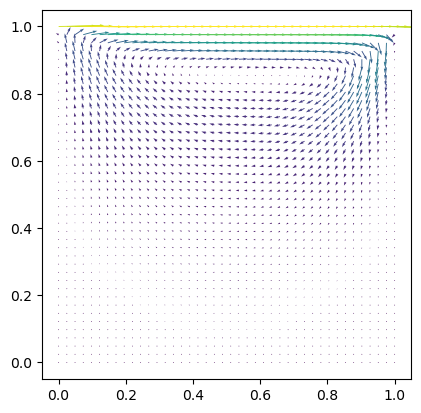

 58%|█████▊    | 58/100 [00:06<00:05,  8.35it/s]

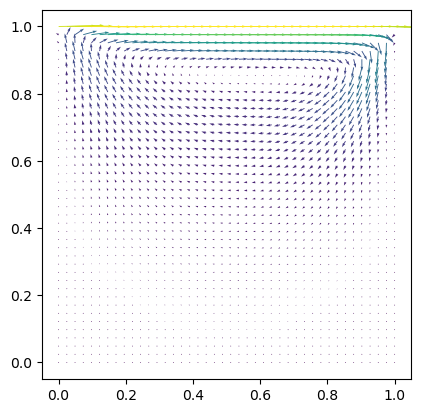

 59%|█████▉    | 59/100 [00:06<00:04,  8.59it/s]

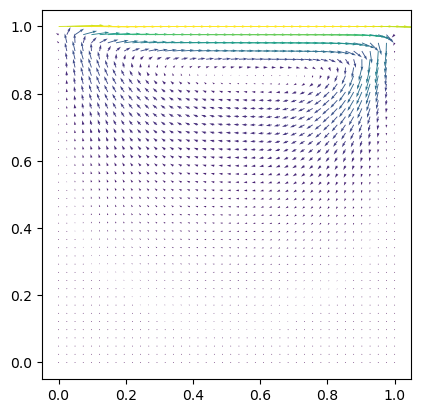

 60%|██████    | 60/100 [00:06<00:04,  8.76it/s]

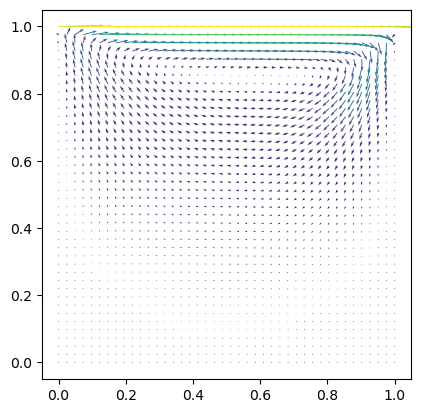

 61%|██████    | 61/100 [00:07<00:04,  8.88it/s]

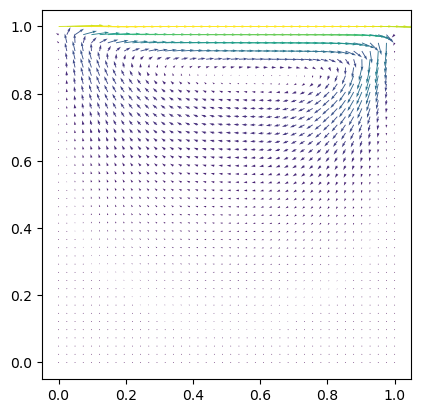

 62%|██████▏   | 62/100 [00:07<00:04,  8.62it/s]

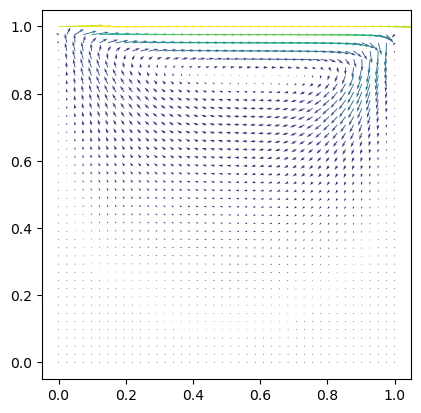

 63%|██████▎   | 63/100 [00:07<00:04,  8.37it/s]

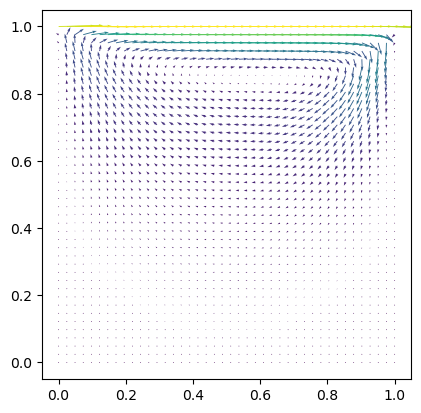

 64%|██████▍   | 64/100 [00:07<00:04,  8.12it/s]

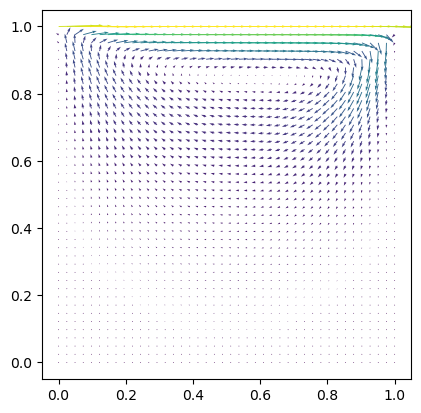

 65%|██████▌   | 65/100 [00:07<00:05,  6.97it/s]

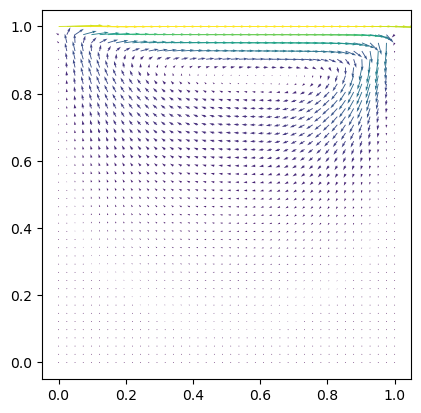

 66%|██████▌   | 66/100 [00:07<00:04,  7.45it/s]

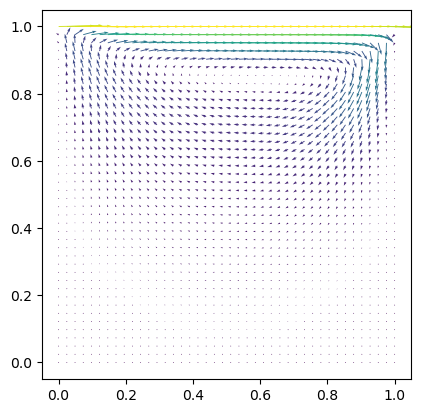

 67%|██████▋   | 67/100 [00:07<00:04,  7.86it/s]

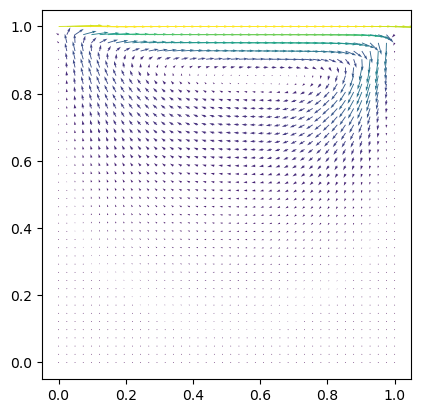

 68%|██████▊   | 68/100 [00:07<00:04,  7.97it/s]

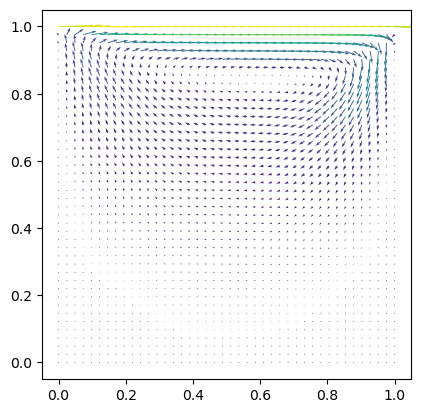

 69%|██████▉   | 69/100 [00:08<00:03,  8.22it/s]

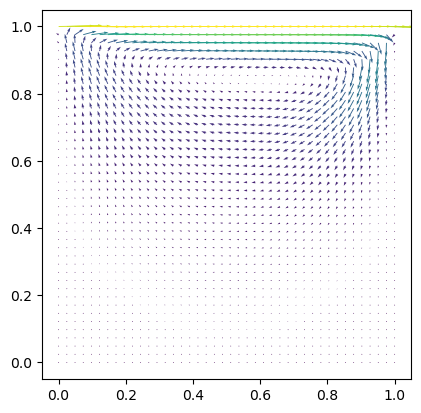

 70%|███████   | 70/100 [00:08<00:03,  8.47it/s]

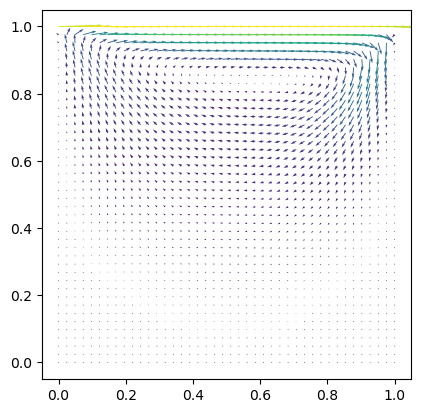

 71%|███████   | 71/100 [00:08<00:03,  8.59it/s]

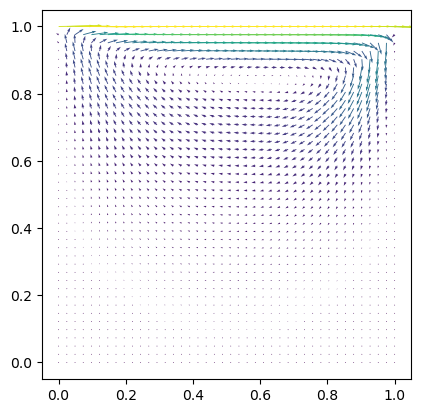

 72%|███████▏  | 72/100 [00:08<00:03,  8.73it/s]

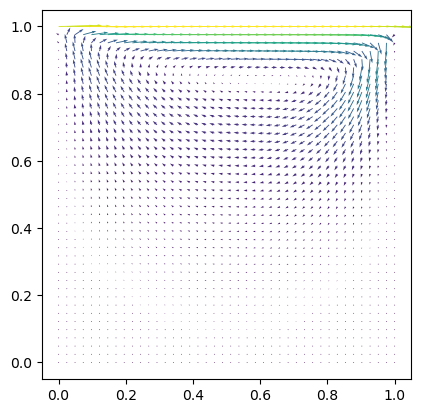

 73%|███████▎  | 73/100 [00:08<00:03,  8.78it/s]

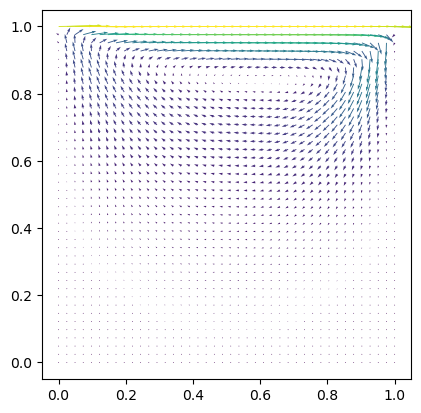

 74%|███████▍  | 74/100 [00:08<00:03,  7.20it/s]

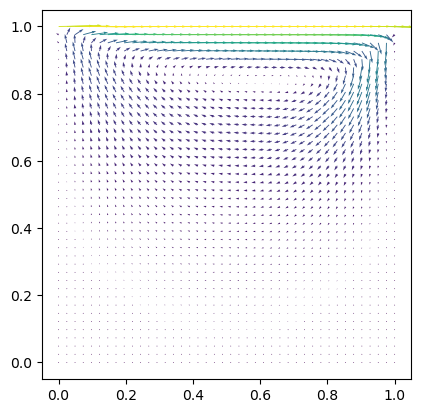

 75%|███████▌  | 75/100 [00:08<00:03,  7.65it/s]

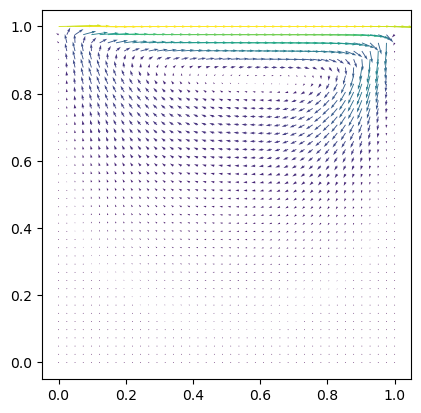

 76%|███████▌  | 76/100 [00:08<00:03,  7.96it/s]

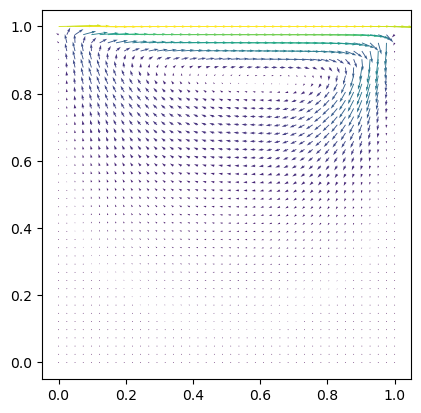

 77%|███████▋  | 77/100 [00:09<00:02,  8.21it/s]

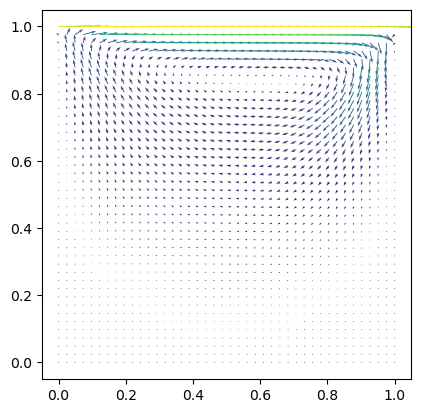

 78%|███████▊  | 78/100 [00:09<00:02,  8.41it/s]

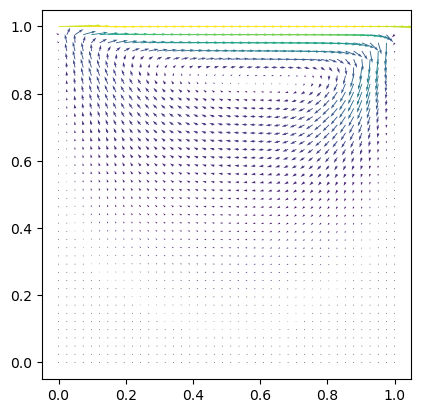

 79%|███████▉  | 79/100 [00:09<00:02,  8.55it/s]

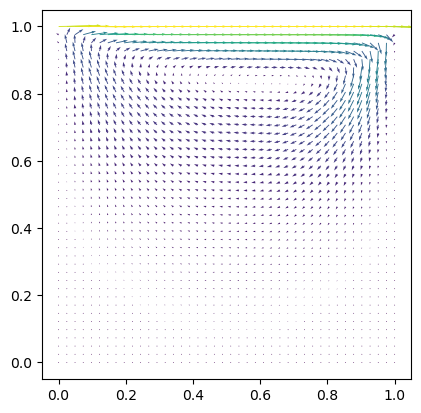

 80%|████████  | 80/100 [00:09<00:02,  8.60it/s]

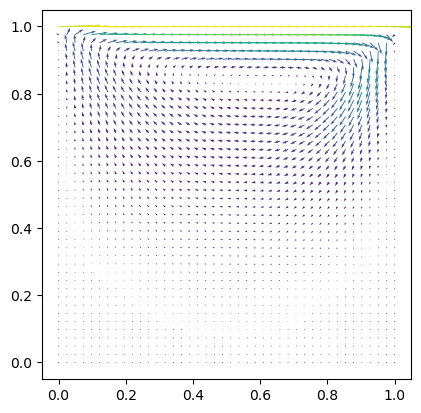

 81%|████████  | 81/100 [00:09<00:02,  8.60it/s]

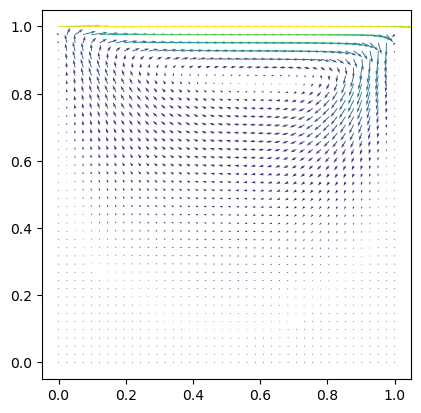

 82%|████████▏ | 82/100 [00:09<00:02,  8.55it/s]

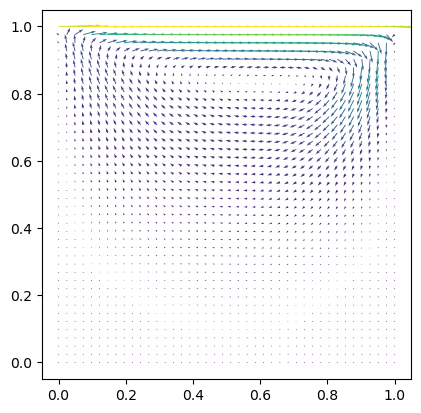

 83%|████████▎ | 83/100 [00:09<00:02,  7.22it/s]

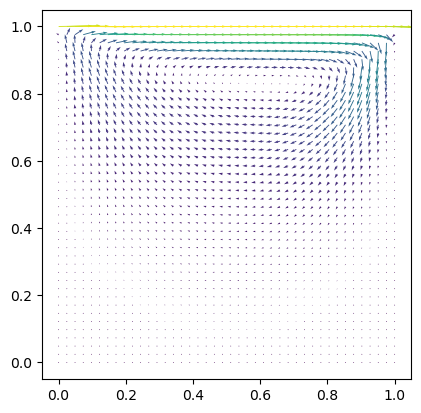

 84%|████████▍ | 84/100 [00:09<00:02,  7.64it/s]

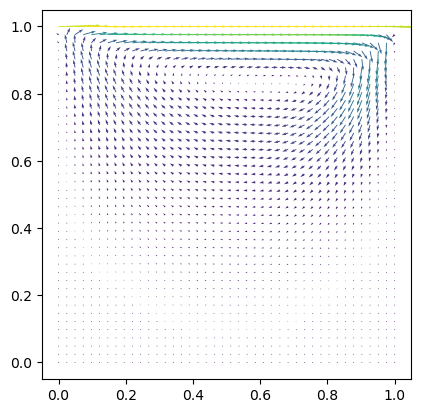

 85%|████████▌ | 85/100 [00:10<00:01,  8.06it/s]

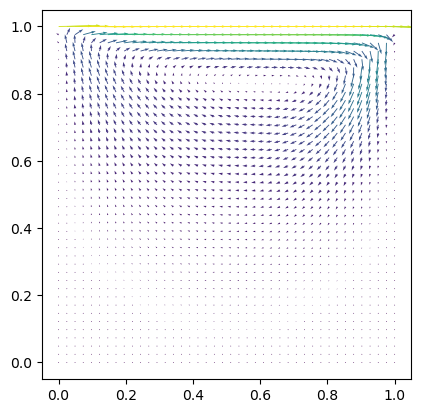

 86%|████████▌ | 86/100 [00:10<00:01,  8.38it/s]

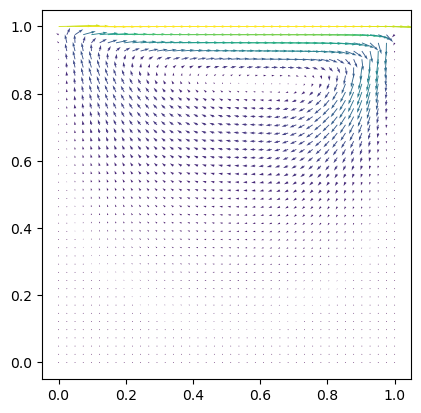

 87%|████████▋ | 87/100 [00:10<00:01,  8.64it/s]

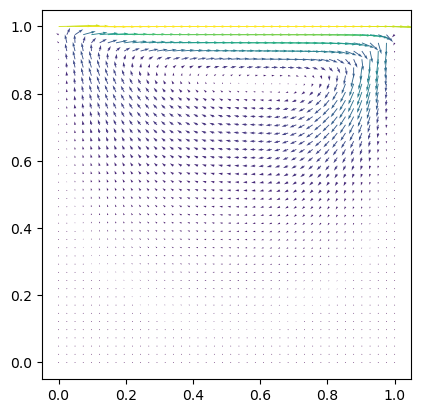

 88%|████████▊ | 88/100 [00:10<00:01,  8.81it/s]

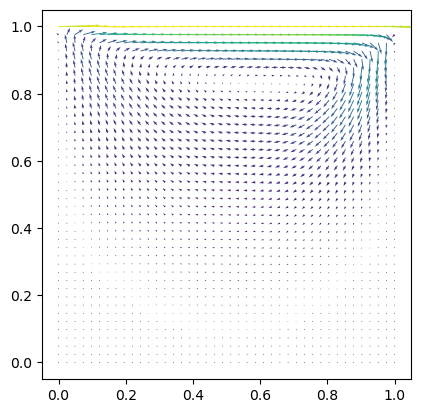

 89%|████████▉ | 89/100 [00:10<00:01,  8.96it/s]

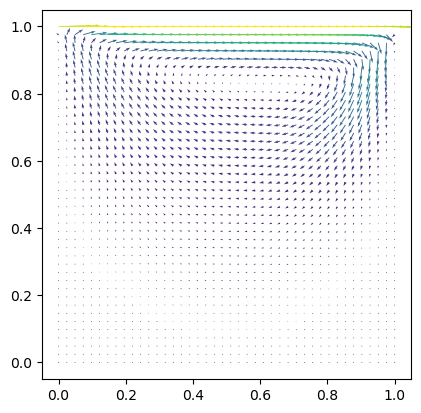

 90%|█████████ | 90/100 [00:10<00:01,  9.02it/s]

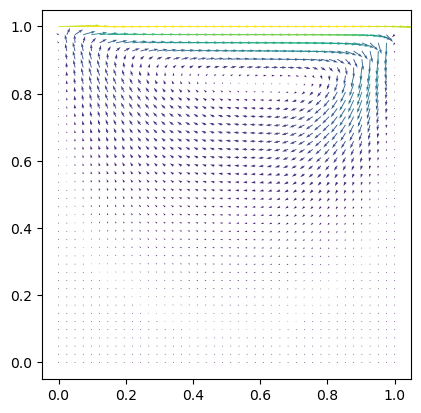

 91%|█████████ | 91/100 [00:10<00:00,  9.11it/s]

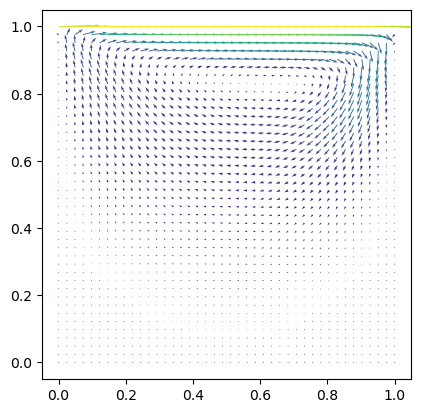

 92%|█████████▏| 92/100 [00:10<00:01,  7.52it/s]

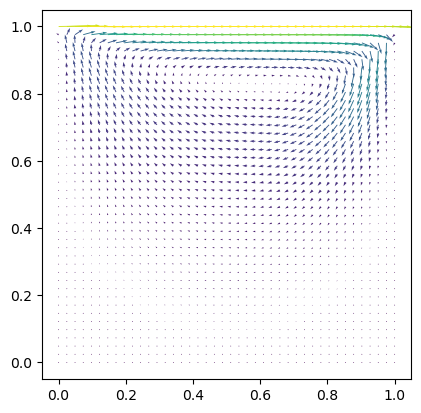

 93%|█████████▎| 93/100 [00:10<00:00,  7.94it/s]

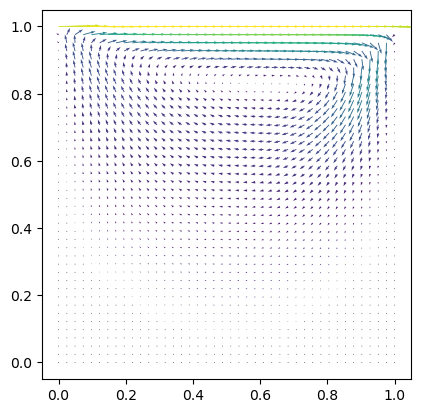

 94%|█████████▍| 94/100 [00:11<00:00,  8.22it/s]

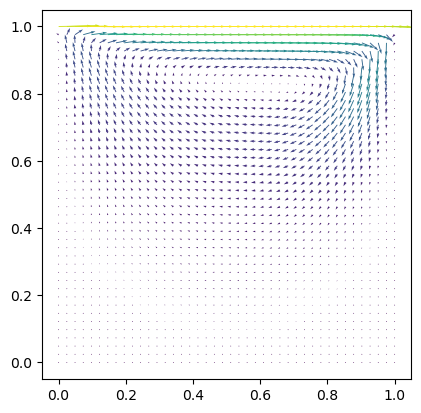

 95%|█████████▌| 95/100 [00:11<00:00,  8.47it/s]

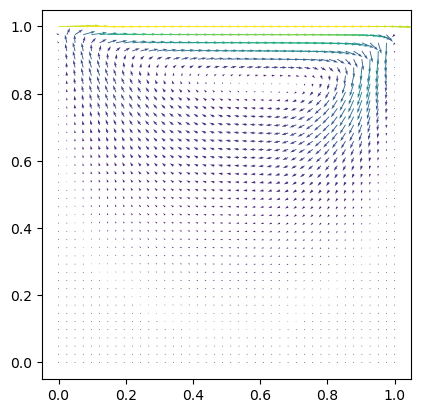

 96%|█████████▌| 96/100 [00:11<00:00,  8.61it/s]

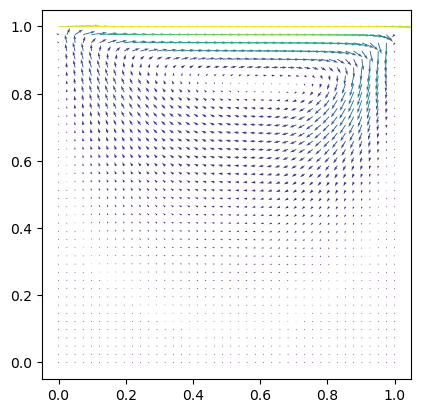

 97%|█████████▋| 97/100 [00:11<00:00,  8.70it/s]

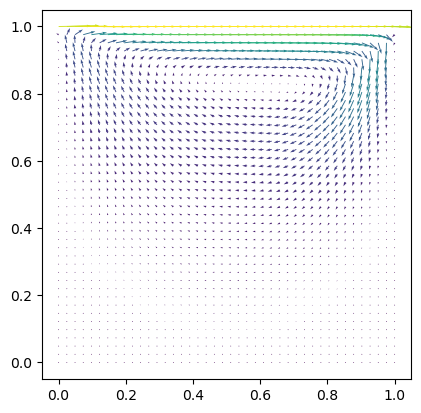

 98%|█████████▊| 98/100 [00:11<00:00,  8.72it/s]

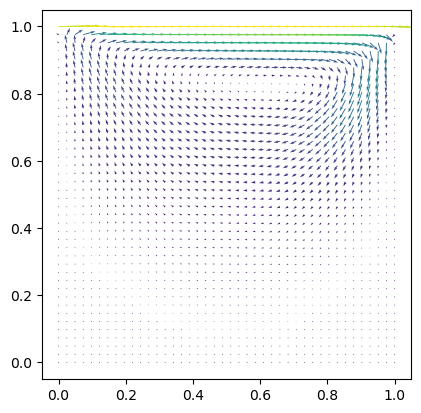

 99%|█████████▉| 99/100 [00:11<00:00,  8.79it/s]

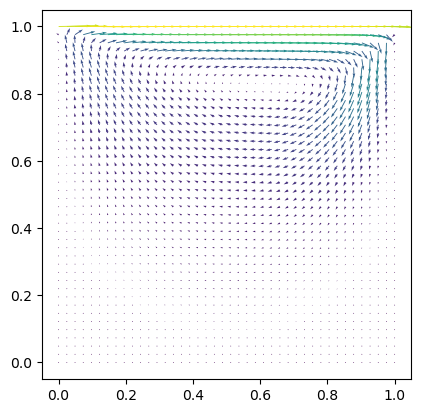

100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


<Figure size 640x480 with 0 Axes>

In [22]:
for t in tqdm(range(N_TIME_STEPS)):
    # (1) Obteniendo la velocidad tentativa
    momentum_assembled_rhs = assemble(momentum_weak_form_rhs)
    [bc.apply(momentum_assembled_system_matrix, momentum_assembled_rhs) for bc in velocity_boundary_conditions]
    solve(
        momentum_assembled_system_matrix,
        u_tent.vector(),
        momentum_assembled_rhs,
        "gmres",
        "ilu",
    )

    # (2) Obteniendo la presión
    pressure_poisson_assembled_rhs = assemble(pressure_poisson_weak_form_rhs)
    solve(
        pressure_poisson_assembled_system_matrix,
        p_next.vector(),
        pressure_poisson_assembled_rhs,
        "gmres",
        "amg",
    )

    # (3) Obteniendo la velocidad final corregiendo con la condición de incompresibilidad
    [bc.apply(momentum_assembled_system_matrix, momentum_assembled_rhs) for bc in velocity_boundary_conditions]
    velocity_update_assembled_rhs = assemble(velocity_update_weak_form_rhs)
    solve(
        velocity_update_assembled_system_matrix,
        u_next.vector(),
        velocity_update_assembled_rhs,
        "gmres",
        "ilu",
    )

    # Siguiente iteración de tiempo
    u_prev.assign(u_next)

    # Visualización
    plot(u_next)
    plt.draw()
    plt.pause(0.02)
    plt.clf()